# Tutorial 2. Advanced capabilities of the MeasurementControl

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Tutorial 2. Advanced capabilities of the MeasurementControl.ipynb`
```

Following this Tutorial requires familiarity with the **core concepts** of Quantify, we **highly recommended** to consult the (short) {ref}`User guide` before proceeding (see Quantify documentation). If you have some difficulties following the tutorial it might be worth reviewing the {ref}`User guide`!

We **highly recommended** beginning with {ref}`Tutorial 1. Controlling a basic experiment using MeasurementControl` before proceeding.

In this tutorial, we will explore the more advanced features of Quantify. By the end of this tutorial, we will have covered:

- Using hardware to drive experiments
- Software averaging
- Interrupting an experiment

In [1]:
import os
import signal
import sys
import time

import numpy as np
from lmfit import Model
from qcodes import ManualParameter

import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.data.handling import set_datadir, default_datadir
from quantify_core.measurement.control import MeasurementControl
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

rng = np.random.default_rng(seed=222222)  # random number generator

**Before instantiating any instruments or starting a measurement** we change the
directory in which the experiments are saved using the
{meth}`~quantify_core.data.handling.set_datadir`
\[{meth}`~quantify_core.data.handling.get_datadir`\] functions.

----------------------------------------------------------------------------------------

⚠️ **Warning!**

We recommend always setting the directory at the start of the Python kernel and sticking to a single common data directory for all notebooks/experiments within your
measurement setup/PC.

The cell below sets a default data directory (`~/quantify-data` on Linux/macOS or
`$env:USERPROFILE\\quantify-data` on Windows) for tutorial purposes. Change it to your
desired data directory. The utilities to find/search/extract data only work if
all the experiment containers are located within the same directory.

----------------------------------------------------------------------------------------

In [2]:
set_datadir('D:\HW\量子元件實驗室\Qblox\Qblox_datadir')  # change me!

In [3]:
meas_ctrl = MeasurementControl("meas_ctrl")
plotmon = pqm.PlotMonitor_pyqt("plotmon_meas_ctrl")
meas_ctrl.instr_plotmon(plotmon.name)
insmon = InstrumentMonitor("InstrumentMonitor")

## A 1D Batched loop: Resonator Spectroscopy

### Defining a simple model

In this example, we want to find the resonance of some devices. We expect to find its resonance somewhere in the low 6 GHz range, but manufacturing imperfections make it impossible to know exactly without inspection.

We first create `freq`: a {class}`.Settable` with a {class}`~qcodes.parameters.Parameter` to represent the frequency of the signal probing the resonator, followed by a custom {class}`.Gettable` to mock (i.e. emulate) the resonator.
The {class}`!Resonator` will return a Lorentzian shape centered on the resonant frequency. Our {class}`.Gettable` will read the setpoints from `freq`, in this case a 1D array.

```{note}
The `Resonator` {class}`.Gettable` has a new attribute `.batched` set to `True`. This property informs the {class}`.MeasurementControl` that it will not be in charge of iterating over the setpoints, instead the `Resonator` manages its own data acquisition. Similarly, the `freq` {class}`.Settable` must have a `.batched=True` so that the {class}`.MeasurementControl` hands over the setpoints correctly.
```

In [4]:
# Note that in an actual experimental setup `freq` will be a QCoDeS parameter
# contained in a QCoDeS Instrument
freq = ManualParameter(name="frequency", unit="Hz", label="Frequency")
freq.batched = True  # Tells meas_ctrl that the setpoints are to be passed in batches


def lorenz(amplitude: float, fwhm: float, x: int, x_0: float):
    """Model of the frequency response."""
    return amplitude * ((fwhm / 2.0) ** 2) / ((x - x_0) ** 2 + (fwhm / 2.0) ** 2)


class Resonator:
    """
    Note that the Resonator is a valid Gettable not because of inheritance,
    but because it has the expected attributes and methods.
    """

    def __init__(self) -> None:
        self.name = "resonator"
        self.unit = "V"
        self.label = "Amplitude"
        self.batched = True
        self.delay = 0.0

        # hidden variables specifying the resonance
        self._test_resonance = 6.0001048e9  # in Hz
        self._test_width = 300  # FWHM in Hz

    def get(self) -> float:
        """Emulation of the frequency response."""
        time.sleep(self.delay)
        _lorenz = lambda x: lorenz(1, self._test_width, x, self._test_resonance)
        return 1 - np.array(list(map(_lorenz, freq())))

    def prepare(self) -> None:
        """Adding this print statement is not required but added for illustrative
        purposes."""
        print("\nPrepared Resonator...")

    def finish(self) -> None:
        """Adding this print statement is not required but added for illustrative
        purposes."""
        print("\nFinished Resonator...")


gettable_res = Resonator()

### Running the experiment

Just like our Iterative 1D loop, our complete experiment is expressed in just four lines of code.

The main difference is defining the `batched` property of our {class}`.Gettable` to `True`.
The {class}`.MeasurementControl` will detect these settings and run in the appropriate mode.

At this point the `freq` parameter is empty:

In [5]:
print(freq())

None


In [6]:
meas_ctrl.settables(freq)
meas_ctrl.setpoints(np.arange(6.0001e9, 6.00011e9, 5))
meas_ctrl.gettables(gettable_res)
dset = meas_ctrl.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 frequency 
Batch size limit: 2000


Prepared Resonator...
100% completed | elapsed time:      0s | time left:      0s  last batch size:   2000  
100% completed | elapsed time:      0s | time left:      0s  last batch size:   2000  
Finished Resonator...


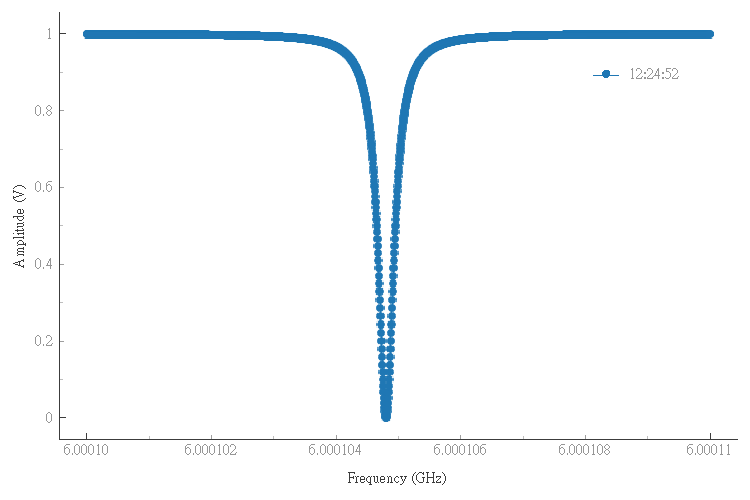

In [7]:
plotmon.main_QtPlot

As expected, we find a Lorentzian spike in the readout at the resonant frequency, finding the peak of which is trivial.

#### Memory-limited Settables/Gettables

Instruments (either physical or virtual) operating in `batched` mode have an upper limit on how many datapoints can be processed at once.
When an experiment is comprised of more datapoints than the instrument can handle, the {class}`.MeasurementControl` takes care of fulfilling the measurement of all the requested setpoints by running and an internal loop.

By default the {class}`.MeasurementControl` assumes no limitations and passes all setpoints to the `batched` settable. However, as a best practice, the instrument limitation must be reflected by the `.batch_size` attribute of the `batched` settables. This is illustrated below.

每批batch的資料量可以自行設定

In [10]:
# Tells meas_ctrl that only 256 datapoints can be processed at once
freq.batch_size = 256

gettable_res.delay = 0.05  # short delay for plotting
meas_ctrl.settables(freq)
meas_ctrl.setpoints(np.arange(6.0001e9, 6.00011e9, 5))
meas_ctrl.gettables(gettable_res)
dset = meas_ctrl.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 frequency 
Batch size limit: 256


Prepared Resonator...
 12% completed | elapsed time:      0s | time left:      1s  last batch size:    256  
Prepared Resonator...

Prepared Resonator...

Prepared Resonator...

Prepared Resonator...

Prepared Resonator...

Prepared Resonator...

Prepared Resonator...
100% completed | elapsed time:      0s | time left:      0s  last batch size:    208  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    208  
Finished Resonator...


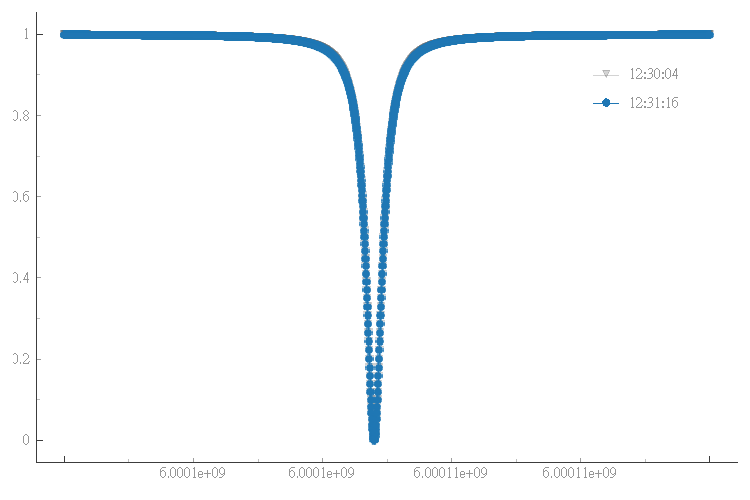

In [11]:
plotmon.main_QtPlot

## Software Averaging: T1 Experiment

In many cases it is desirable to run an experiment many times and average the result, such as when filtering noise on instruments or measuring probability.
For this purpose, the {meth}`.MeasurementControl.run` provides the `soft_avg` argument.
If set to *x*, the experiment will run *x* times whilst performing a running average over each setpoint.

In this example, we want to find the relaxation time (aka T1) of a Qubit. As before, we define a {class}`.Settable` and {class}`.Gettable`, representing the varying timescales we will probe through and a mock Qubit emulated in software.
The mock Qubit returns the expected decay sweep but with a small amount of noise (simulating the variable qubit characteristics). We set the qubit's T1 to 60 ms - obviously in a real experiment we would be trying to determine this, but for this illustration purposes in this tutorial we set it to a known value to verify our fit later on.

Note that in this example meas_ctrl is still running in Batched mode.

In [18]:
def decay(t, tau):
    """T1 experiment decay model."""
    return np.exp(-t / tau)


time_par = ManualParameter(name="time", unit="s", label="Measurement Time")
# Tells meas_ctrl that the setpoints are to be passed in batches
time_par.batched = True


class MockQubit:
    """A mock qubit."""

    def __init__(self):
        self.name = "qubit"
        self.unit = "%"
        self.label = "High V"
        self.batched = True

        self.delay = 0.01  # sleep time in secs
        self.test_relaxation_time = 60e-6

    def get(self):
        """Adds a delay to be able to appreciate the data acquisition."""
        time.sleep(self.delay)
        rel_time = self.test_relaxation_time
        _func = lambda x: decay(x, rel_time) + rng.uniform(-0.1, 0.1)
        "rng.uniform(-0.1, 0.1) 就是noise"
        return np.array(list(map(_func, time_par())))

We will then sweep through 0 to 300 ms, getting our data from the mock Qubit. Let's first observe what a single run looks like:

In [19]:
meas_ctrl.settables(time_par)
meas_ctrl.setpoints(np.linspace(0.0, 300.0e-6, 300))
meas_ctrl.gettables(MockQubit())
meas_ctrl.run("noisy")  # by default `.run` uses `soft_avg=1`

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 300

100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  

<xarray.Dataset>
Dimensions:  (dim_0: 300)
Coordinates:
    x0       (dim_0) float64 0.0 1.003e-06 2.007e-06 ... 0.000299 0.0003
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.9795 1.016 0.9418 ... -0.07368 0.003234 0.07999
Attributes:
    tuid:                             20231121-123718-587-f31b26
    name:                             noisy
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

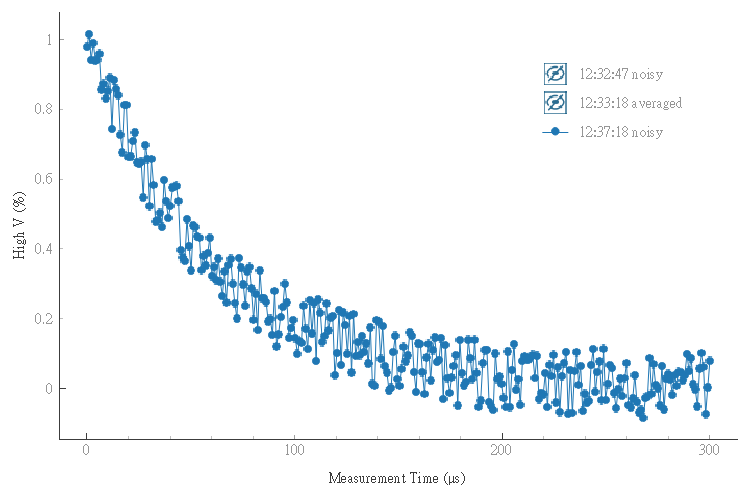

In [21]:
plotmon.main_QtPlot

Alas, the noise in the signal has made this result unusable! Let's set the `soft_avg` argument of the {meth}`.MeasurementControl.run` to 100, averaging the results and hopefully filtering out the noise.

softavg就是測好多次取平均

In [30]:
dset = meas_ctrl.run("averaged", soft_avg=10)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 time 
Batch size limit: 300

100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  
100% completed | elapsed time:      0s | time left:      0s  last batch size:    300  

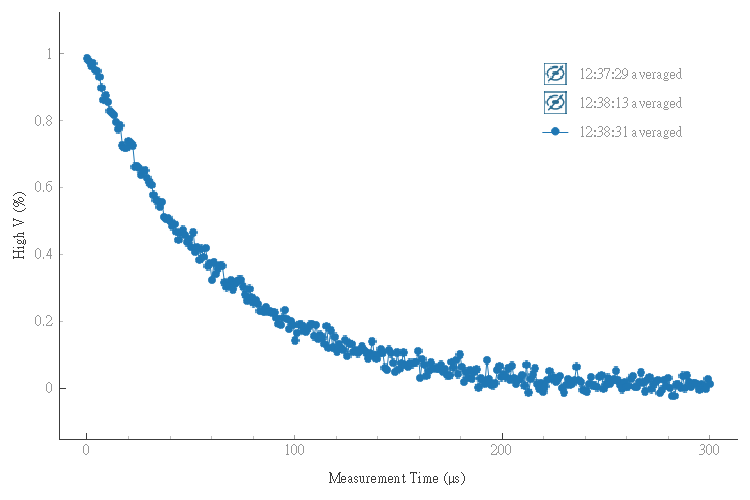

In [31]:
plotmon.main_QtPlot

Success! We now have a smooth decay curve based on the characteristics of our qubit. All that remains is to run a fit against the expected values and we can solve for T1.

{'tau': 5.998008368655346e-05}

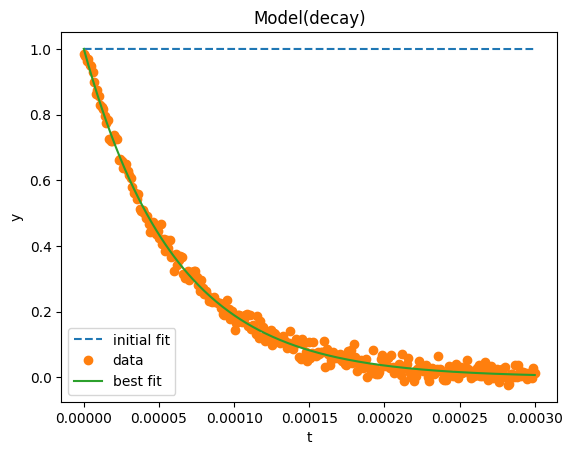

In [32]:
model = Model(decay, independent_vars=["t"])
fit_res = model.fit(dset["y0"].values, t=dset["x0"].values, tau=1)

fit_res.plot_fit(show_init=True)
fit_res.values

## Interrupting
Sometimes experiments, unfortunately, do not go as planned and it is desirable to interrupt and restart them with new parameters. In the following example, we have a long-running experiment where our Gettable is taking a long time to return data (maybe due to misconfiguration).
Rather than waiting for this experiment to complete, instead we can interrupt any {class}`.MeasurementControl` loop using the standard interrupt signal.
In a terminal environment this is usually achieved with a `ctrl` + `c` press on the keyboard or equivalent, whilst in a Jupyter environment interrupting the kernel (stop button) will cause the same result.

When the {class}`.MeasurementControl` is interrupted, it will wait to obtain the results of the current iteration (or batch) and perform a final save of the data it has gathered, calling the `finish()` method on Settables & Gettables (if it exists) and return the partially completed dataset.

```{note}
The exact means of triggering an interrupt will differ depending on your platform and environment; the important part is to cause a `KeyboardInterrupt` exception to be raised in the Python process.
```

In case the current iteration is taking too long to complete (e.g. instruments not responding), you may force the execution of any python code to stop by signaling the same interrupt 5 times (e.g. pressing 5 times `ctrl` + `c`). Mind that performing this too fast might result in the `KeyboardInterrupt` not being properly handled and corrupting the dataset!

In [35]:
class SlowGettable:
    """A mock slow gettables."""

    def __init__(self):
        self.name = "slow"
        self.label = "Amplitude"
        self.unit = "V"

    def get(self):
        """Get method."""
        time.sleep(1.0)
        if time_par() == 5:
            # This same exception rises when pressing `ctrl` + `c`
            # or the "Stop kernel" button is pressed in a Jupyter(Lab) notebook
            if sys.platform == "win32":
                # Emulating the kernel interrupt on windows might have side effects
                raise KeyboardInterrupt
            os.kill(os.getpid(), signal.SIGINT)
        return time_par()


time_par.batched = False
meas_ctrl.settables(time_par)
meas_ctrl.setpoints(np.arange(10))
meas_ctrl.gettables(SlowGettable())
# Try interrupting me!
dset = meas_ctrl.run("slow")

Starting iterative measurement...
 50% completed | elapsed time:      7s | time left:      7s  
Interrupt signaled, exiting gracefully...


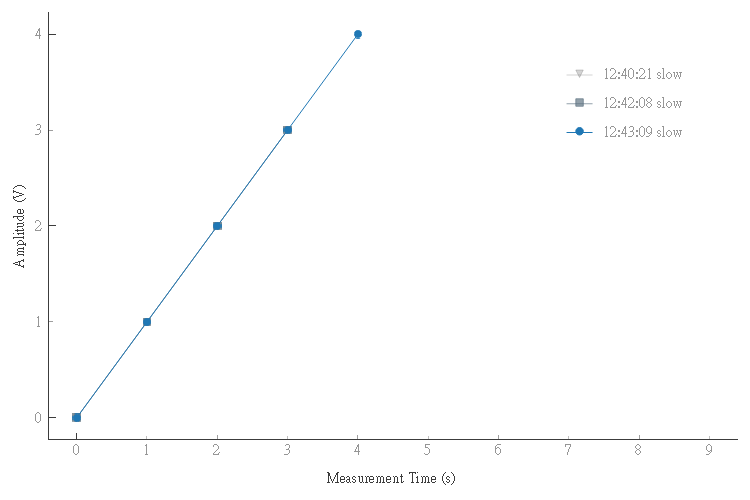

In [36]:
plotmon.main_QtPlot